In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [4]:
df = pd.read_csv("C:/Users/sivay/Downloads/eth.csv", parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
print(df.head())
df.columns

(1742, 38)
            AdrActCnt  BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMrktCurUSD  \
date                                                                         
2015-07-30       9206    6911      4449897       643.886124            NaN   
2015-07-31        424    6863      3994458       582.027976            NaN   
2015-08-01        413    5293      3044344       575.164179            NaN   
2015-08-02        432    5358      3112348       580.878686            NaN   
2015-08-03        444    5280      3099953       587.112311            NaN   

                DiffMean  FeeMeanNtv  FeeMeanUSD  FeeMedNtv  FeeMedUSD  ...  \
date                                                                    ...   
2015-07-30  1.213355e+11         NaN         NaN        NaN        NaN  ...   
2015-07-31  6.029419e+11         NaN         NaN        NaN        NaN  ...   
2015-08-01  8.872542e+11         NaN         NaN        NaN        NaN  ...   
2015-08-02  1.020254e+12         NaN         Na

Index(['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte',
       'CapMrktCurUSD', 'DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv',
       'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD', 'HashRate', 'IssContNtv',
       'IssContPctAnn', 'IssContUSD', 'IssTotNtv', 'IssTotUSD', 'NVTAdj',
       'NVTAdj90', 'PriceBTC', 'PriceUSD', 'ROI1yr', 'ROI30d', 'SplyCur',
       'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValAdjUSD',
       'TxTfrValMeanNtv', 'TxTfrValMeanUSD', 'TxTfrValMedNtv',
       'TxTfrValMedUSD', 'TxTfrValNtv', 'TxTfrValUSD', 'VtyDayRet180d',
       'VtyDayRet30d', 'VtyDayRet60d'],
      dtype='object')

In [5]:
df=df[['PriceUSD','BlkCnt','BlkSizeByte']]
df

,PriceUSD,BlkCnt,BlkSizeByte
date,,,
2015-07-30,NaN,6911,4449897
2015-07-31,NaN,6863,3994458
2015-08-01,NaN,5293,3044344
2015-08-02,NaN,5358,3112348
2015-08-03,NaN,5280,3099953
...,...,...,...
2020-05-01,212.713618,6475,167637394
2020-05-02,214.133871,6471,154402713
2020-05-03,210.090575,6421,159384121


In [6]:
print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1742 entries, 2015-07-30 to 2020-05-05
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PriceUSD     1733 non-null   float64
 1   BlkCnt       1742 non-null   int64  
 2   BlkSizeByte  1742 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 54.4 KB
None


PriceUSD       9
BlkCnt         0
BlkSizeByte    0
dtype: int64

In [7]:
df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)
#df.PriceUSD= df.PriceUSD.astype(np.int64)

In [8]:

df


,PriceUSD,BlkCnt,BlkSizeByte
date,,,
2015-08-08,1.199990,5256,3508878
2015-08-09,1.199990,5123,3167541
2015-08-10,1.199990,5255,3316883
2015-08-11,0.990000,5280,3653834
2015-08-12,1.288000,5124,3348157
...,...,...,...
2020-05-01,212.713618,6475,167637394
2020-05-02,214.133871,6471,154402713
2020-05-03,210.090575,6421,159384121


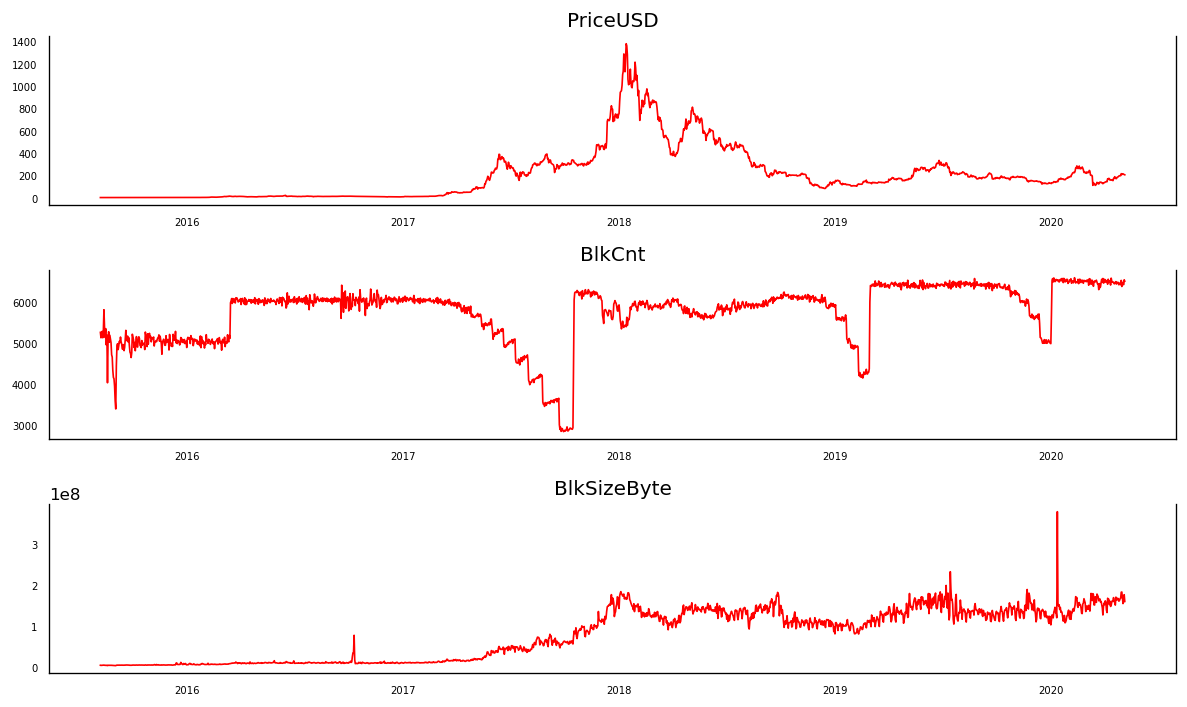

In [11]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,PriceUSD_x,BlkCnt_x,BlkSizeByte_x
PriceUSD_y,1.0000,0.7472,0.0204
BlkCnt_y,0.3512,1.0000,0.0757
BlkSizeByte_y,0.0007,0.0791,1.0000


Here we cannot reject the null hyothesis for most of them as the p values are not significant. However, PriceUSD and BlkSizeByte have a relation as per the above table.

In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
PriceUSD ::  8.64      > 24.2761   =>   False
BlkCnt ::  3.22      > 12.3212   =>   False
BlkSizeByte ::  0.02      > 4.1296    =>   False


In [14]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(1729, 3)
(4, 3)


In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [16]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PriceUSD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3411
 No. Lags Chosen       = 25
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.159. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "BlkCnt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5035
 No. Lags Chosen       = 3
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0079. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BlkSizeByte" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-S

In [17]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [18]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PriceUSD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9724
 No. Lags Chosen       = 24
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BlkCnt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.4541
 No. Lags Chosen       = 2
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BlkSizeByte" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance L

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [20]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  48.35359442898085
BIC :  48.39149234035187
FPE :  9.993077406784653e+20
HQIC:  48.36761323237235 

Lag Order = 2
AIC :  48.286831338556155
BIC :  48.3531840612123
FPE :  9.347693347760378e+20
HQIC:  48.31137656735797 

Lag Order = 3
AIC :  48.25428290681786
BIC :  48.349117382112915
FPE :  9.04834109585435e+20
HQIC:  48.289365142121085 

Lag Order = 4
AIC :  48.24397668589541
BIC :  48.36731989679896
FPE :  8.955569986507382e+20
HQIC:  48.289606525600945 

Lag Order = 5
AIC :  48.201059264234324
BIC :  48.35293823542025
FPE :  8.579357317402385e+20
HQIC:  48.25724732308925 

Lag Order = 6
AIC :  48.12949419576118
BIC :  48.309935993696314
FPE :  7.986838685547849e+20
HQIC:  48.1962511053952 

Lag Order = 7
AIC :  48.133065619438526
BIC :  48.342097352471626
FPE :  8.015426022843586e+20
HQIC:  48.21040202840051 

Lag Order = 8
AIC :  48.135520643133184
BIC :  48.37316946158409
FPE :  8.03514403833327e+20
HQIC:  48.22344721692785 

Lag Order = 9
AIC :  48.13291261733

C:\Users\sivay\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In the above output, the AIC drops to lowest at lag 6, then increases at lag 7 
Let’s go with the lag 6 model.

An alternate method to choose t

In [21]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Dec, 2020
Time:                     15:20:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    48.3099
Nobs:                     1722.00    HQIC:                   48.1963
Log likelihood:          -48712.7    FPE:                7.98684e+20
AIC:                      48.1295    Det(Omega_mle):     7.72819e+20
--------------------------------------------------------------------
Results for equation PriceUSD
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.080678         0.458962            0.176           0.860
L1.PriceUSD            0.039299         0.023979            1.639           0.101
L1.BlkCnt             -0.001201         0.003386     

In [23]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 6

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

6


array([[ 3.27723834e+00,  4.00000000e+01,  1.46779300e+06],
       [-4.96731590e-01, -5.00000000e+00,  4.44261400e+06],
       [ 9.00703887e-01, -3.30000000e+01,  1.01070200e+06],
       [ 1.79175395e+01,  1.06000000e+02,  1.49775500e+07],
       [-8.49908679e+00, -1.49000000e+02,  5.28768000e+05],
       [ 5.82875248e+00,  9.80000000e+01, -1.51475260e+07]])

In [25]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,PriceUSD_1d,BlkCnt_1d,BlkSizeByte_1d
date,,,
2020-05-02,2.201607,-12.946578,4.938874e+05
2020-05-03,0.040727,15.313329,1.602403e+06
2020-05-04,3.618736,-5.803055,6.038488e+05
2020-05-05,1.732369,-1.570566,1.320597e+06


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [36]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['PriceUSD_forecast','BlkCnt_forecast','BlkSizeByte_forecast']]

,PriceUSD_forecast,BlkCnt_forecast,BlkSizeByte_forecast
date,,,
2020-05-02,214.915225,6462.053422,1.681313e+08
2020-05-03,214.955952,6477.366751,1.697337e+08
2020-05-04,218.574688,6471.563697,1.703375e+08
2020-05-05,220.307057,6469.993131,1.716581e+08


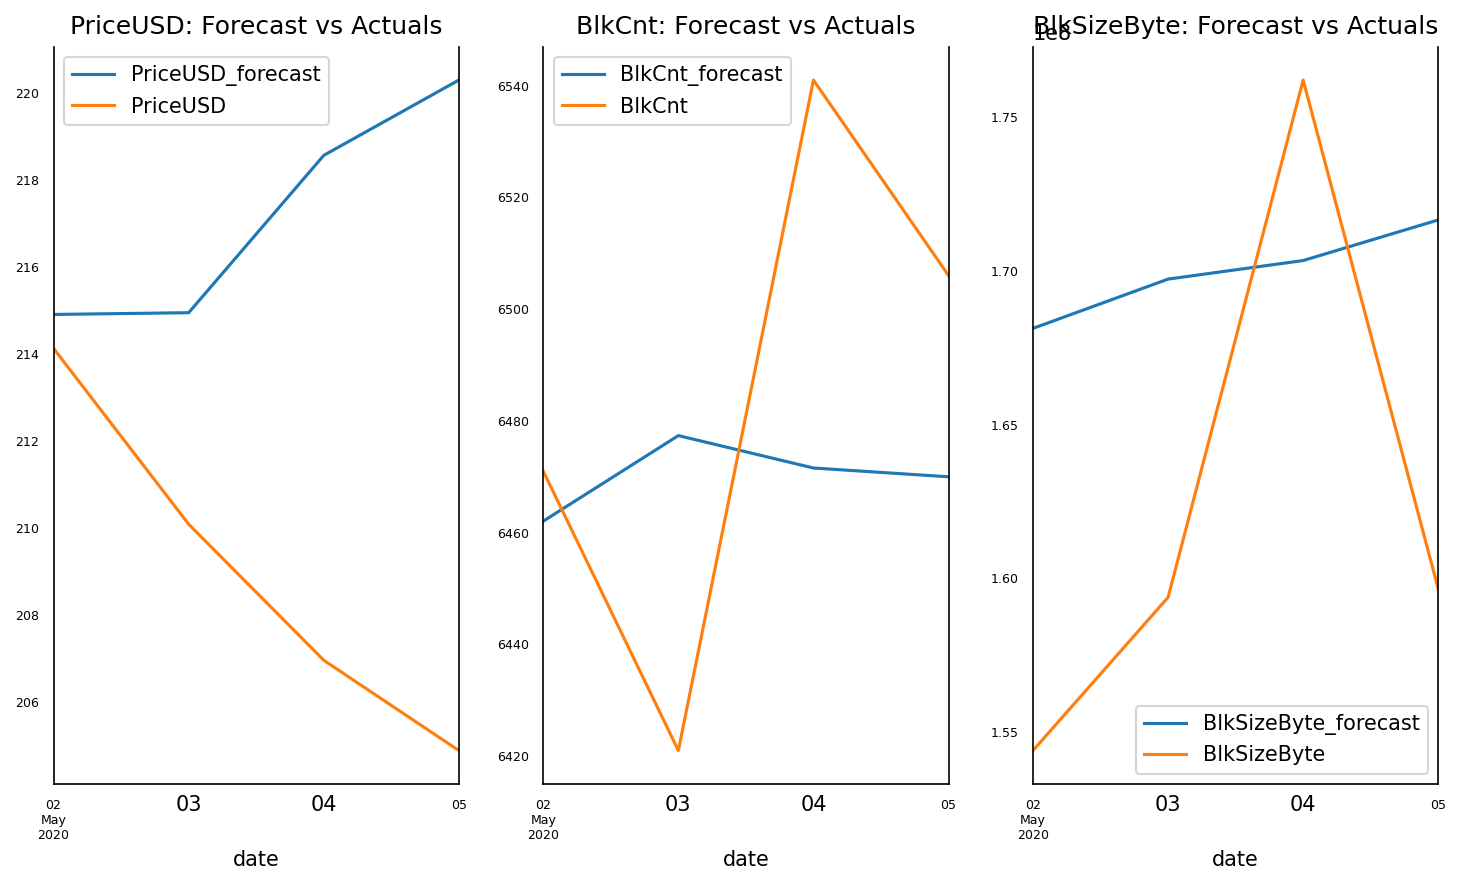

In [42]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=3, dpi=150, figsize=(10,6))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();